In [1]:
import pandas as pd
import numpy as np

## Model data preparation

In [2]:
population = 35330888
number_hospital_beds = 38004
number_icu_beds = 3742

average_R0 = 3
tl = 5
ti = 3
th = 4
tc = 14

In [3]:
simulation_start_date = "2020-03-01"
simulation_end_date = "2020-10-31"

In [4]:
Sa = pd.DataFrame()
betat = pd.DataFrame()
Ia = pd.DataFrame()
Ea = pd.DataFrame()
Ha = pd.DataFrame()
Ca = pd.DataFrame()
Ra = pd.DataFrame()
Da = pd.DataFrame()

zetaa = pd.DataFrame()
ma = pd.DataFrame()
fa = pd.DataFrame()
ca = pd.DataFrame()
sa0 = pd.DataFrame()

CONVERT_PERCENTAGE = 1
CONVERT_TO_ABS_POPULATION = 0
sa0_file = "./data/population_age_distribution.csv"
ma_file = "./data/agebased_recovery.csv"
ca_file = "./data/agebased_criticalcare.csv"
fa_file = "./data/agebased_fatal.csv"
zetaa_file = "./data/agebased_zetaa.csv"

age_map_dict = {0:"0-9",1:"10-19",
    2:"20-29", 3:"30-39",
    4:"40-49", 5:"50-59",
    6:"60-69", 7:"70-79",
    8:"80-"}
age_code_end = 9

agestring = pd.DataFrame.from_dict(age_map_dict, orient="index")
agestring.columns = ["AgeString"]

zero_initial_value = pd.DataFrame(index = range(age_code_end))
zero_initial_value["Value"] = 0

infected_initial_value_dict = {0:0,1:0,
    2:2, 3:3,
    4:4, 5:4,
    6:2, 7:0,
    8:0}
infected_initial_value = pd.DataFrame.from_dict(infected_initial_value_dict, orient="index")
infected_initial_value.columns = ["Value"]


In [5]:
def prepare_agebased_data_fromfile(file):
    filedata = pd.read_csv(file, index_col=0)
    var = pd.DataFrame(columns=["AgeString","Value"])    
    var["AgeString"] = agestring["AgeString"]
    if CONVERT_PERCENTAGE:
        var["Value"] = filedata["Value"]/100
    else:
        var["Value"] = filedata["Value"]
        
    if CONVERT_TO_ABS_POPULATION:
        var["Value"] = var["Value"] * population
    
    return var


def prepare_timeseries_data(initial_value):
    var = pd.DataFrame(index = pd.date_range(simulation_start_date, simulation_end_date), \
        columns = range(age_code_end))
    for a in range(age_code_end):
        var.iloc[0][a] = initial_value.loc[a]["Value"]
    return var

ma = prepare_agebased_data_fromfile(ma_file)
ca = prepare_agebased_data_fromfile(ca_file)
fa = prepare_agebased_data_fromfile(fa_file)
zetaa = prepare_agebased_data_fromfile(zetaa_file)

CONVERT_TO_ABS_POPULATION = 1
sa0 = prepare_agebased_data_fromfile(sa0_file)

Sa = prepare_timeseries_data(sa0)
Ia = prepare_timeseries_data(infected_initial_value)
Ea = prepare_timeseries_data(zero_initial_value)
Ha = prepare_timeseries_data(zero_initial_value)
Ca = prepare_timeseries_data(zero_initial_value)
Ra = prepare_timeseries_data(zero_initial_value)
Da = prepare_timeseries_data(zero_initial_value)
betat = prepare_timeseries_data(zero_initial_value)

## Model simulation

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
dt = 1

In [8]:
def limit(value):
    return np.min([population, np.max([value, 0])])

In [9]:
for sim_time in pd.date_range(simulation_start_date, simulation_end_date):
    # end the simulation if we are at the last row
    if (sim_time + 1) > pd.Timestamp(simulation_end_date):
        continue
        
    total_infected = np.sum(Ia.loc[sim_time])
    for a in range(age_code_end):
        betat.loc[sim_time][a] = average_R0 * (1 - (zetaa.loc[a]["Value"]))/population
        Sa.loc[sim_time + 1][a] = limit(Sa.loc[sim_time][a] - betat.loc[sim_time][a] * Sa.loc[sim_time][a] * total_infected)
        Ea.loc[sim_time + 1][a] = limit(Ea.loc[sim_time][a] + betat.loc[sim_time][a] * Sa.loc[sim_time][a] * total_infected - Ea.loc[sim_time][a]/tl)
        Ia.loc[sim_time + 1][a] = limit(Ia.loc[sim_time][a] + Ea.loc[sim_time][a]/tl - Ia.loc[sim_time][a]/ti)
        Ha.loc[sim_time + 1][a] = limit(Ha.loc[sim_time][a] + (1 - ma.loc[a]["Value"])/ti * Ia.loc[sim_time][a] + \
                                        (1 - fa.loc[a]["Value"])/tc * Ca.loc[sim_time][a] - \
                                        Ha.loc[sim_time][a]/th)
        Ca.loc[sim_time + 1][a] = limit(Ca.loc[sim_time][a] + ca.loc[a]["Value"] * Ha.loc[sim_time][a]/th - \
                                       Ca.loc[sim_time][a]/tc)
        Ra.loc[sim_time + 1][a] = limit(Ra.loc[sim_time][a] + ma.loc[a]["Value"] * Ia.loc[sim_time][a]/ti + \
                                       (1 - ca.loc[a]["Value"]) * Ha.loc[sim_time][a]/th)
        Da.loc[sim_time + 1][a] = limit(Da.loc[sim_time][a] + fa.loc[a]["Value"] * Ca.loc[sim_time][a]/tc)

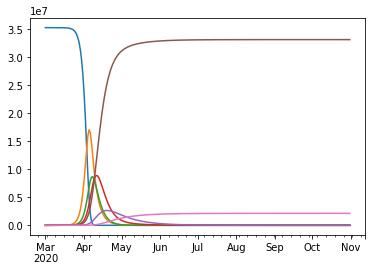

In [10]:
Sa.sum(axis = 1).plot()
Ea.sum(axis = 1).plot()
Ia.sum(axis = 1).plot()
Ha.sum(axis = 1).plot()
Ca.sum(axis = 1).plot()
Ra.sum(axis = 1).plot()
Da.sum(axis = 1).plot()

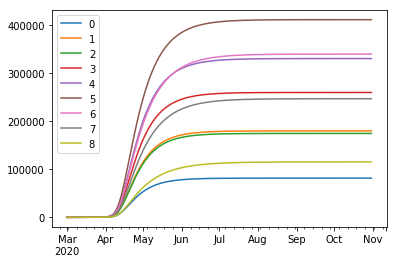

In [12]:
Da.plot()